In [31]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.15.0


In [32]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Input, Dropout
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.models import Model
import seaborn as sns
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping
import joblib


In [33]:
df = pd.read_csv('//content/ec2_cpu_utilization_24ae8d.csv')
df = df[['timestamp', 'value']]
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.head()

,timestamp,value
0,2014-02-14 14:30:00,0.132
1,2014-02-14 14:35:00,0.134
2,2014-02-14 14:40:00,0.134
3,2014-02-14 14:45:00,0.134
4,2014-02-14 14:50:00,0.134


In [34]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df['timestamp'], y=df['value'], name='cpu usage'))
fig.update_layout(showlegend=True, title='cpu usage')
fig.show()

In [35]:
print("Start date is: ", df['timestamp'].min())
print("End date is: ", df['timestamp'].max())


Start date is:  2014-02-14 14:30:00
End date is:  2014-02-28 14:25:00


# **Data Preprocessing**

In [36]:
train = df.loc[df['timestamp'] <= '2014-02-25 14:30:00']
test = df.loc[df['timestamp'] > '2014-02-25 14:30:00']
train.shape, test.shape

((3169, 2), (863, 2))

In [37]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.array(train['value']).reshape(-1,1))
joblib.dump(scaler, 'scaler.pkl')

train['value'] = scaler.transform(np.array(train['value']).reshape(-1,1))
test['value'] = scaler.transform(np.array(test['value']).reshape(-1,1))


<ipython-input-37-3147655708f1>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-3147655708f1>:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



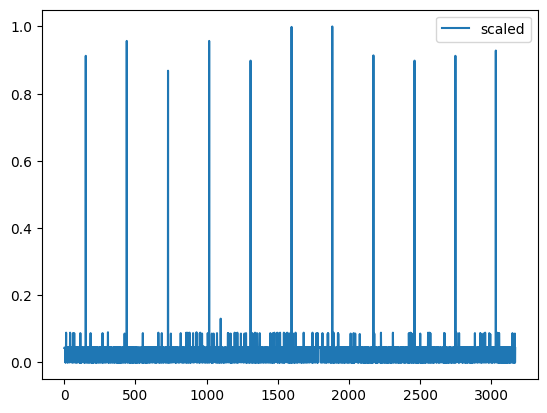

In [38]:
plt.plot(train['value'], label = 'scaled')
plt.legend()
plt.show()

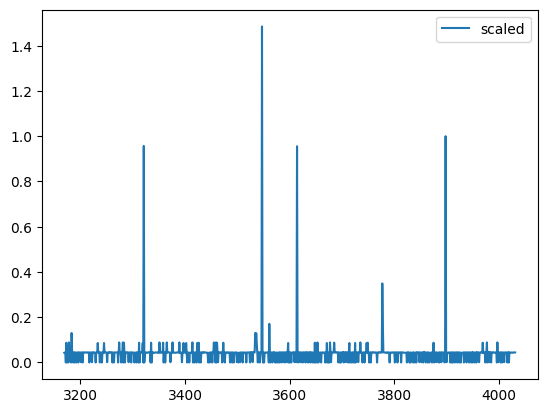

In [39]:
plt.plot(test['value'], label = 'scaled')
plt.legend()
plt.show()

In [40]:
TIME_STEPS=290

def create_sequences(X, y, time_steps=TIME_STEPS):
    X_out, y_out = [], []
    for i in range(len(X)-time_steps):
        X_out.append(X.iloc[i:(i+time_steps)].values)
        y_out.append(y.iloc[i+time_steps])

    return np.array(X_out), np.array(y_out)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])
print("Training input shape: ", X_train.shape)
print("Testing input shape: ", X_test.shape)

Training input shape:  (2879, 290, 1)
Testing input shape:  (573, 290, 1)


In [41]:
#X_train[3158]

## **Build a model**

In [42]:
model = Sequential()
model.add(LSTM(128, activation = 'tanh',kernel_initializer=HeNormal(), input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, activation = 'tanh', kernel_initializer=HeNormal(), return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse",
metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 290, 128)          0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 290, 128)          131584    
                                                                 
 dropout_1 (Dropout)         (None, 290, 128)          0         
                                                                 
 time_distributed (TimeDist  (None, 290, 1)            129       
 ributed)                                               

# **Train Model**

In [43]:
history = model.fit(X_train,
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=5, mode='min')],
                    shuffle=False)

Epoch 1/100
81/81 [==============================] - 9s 33ms/step - loss: 0.0073 - accuracy: 0.1813 - val_loss: 0.0034 - val_accuracy: 0.1944
Epoch 2/100
81/81 [==============================] - 2s 21ms/step - loss: 0.0038 - accuracy: 0.1814 - val_loss: 0.0032 - val_accuracy: 0.1944
Epoch 3/100
81/81 [==============================] - 2s 22ms/step - loss: 0.0036 - accuracy: 0.1814 - val_loss: 0.0032 - val_accuracy: 0.1944
Epoch 4/100
81/81 [==============================] - 2s 24ms/step - loss: 0.0035 - accuracy: 0.1814 - val_loss: 0.0032 - val_accuracy: 0.1944
Epoch 5/100
81/81 [==============================] - 3s 32ms/step - loss: 0.0034 - accuracy: 0.1814 - val_loss: 0.0032 - val_accuracy: 0.1944
Epoch 6/100
81/81 [==============================] - 2s 22ms/step - loss: 0.0034 - accuracy: 0.1814 - val_loss: 0.0032 - val_accuracy: 0.1944
Epoch 7/100
81/81 [==============================] - 2s 21ms/step - loss: 0.0034 - accuracy: 0.1814 - val_loss: 0.0032 - val_accuracy: 0.1944
Epoch 

In [44]:
from tensorflow.keras.models import save_model
model.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



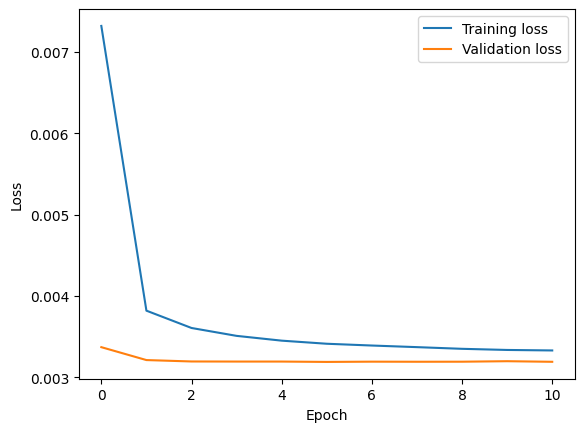

In [45]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend();

90/90 [==============================] - 2s 10ms/step
Reconstruction error threshold: 0.03284761266112032


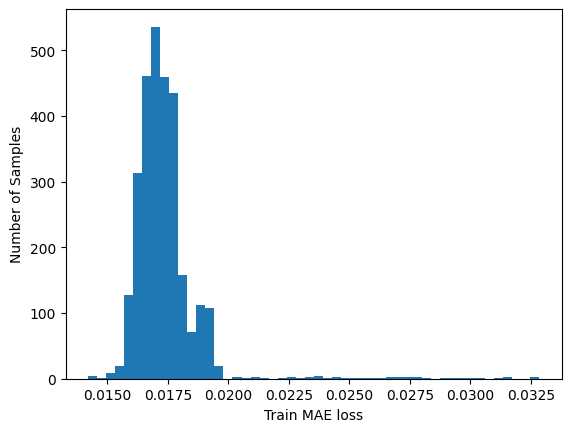

In [46]:
# Mean Absolute Error loss
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');

# Set reconstruction error threshold
threshold = np.max(train_mae_loss)

print('Reconstruction error threshold:',threshold)

# **Predict Anomalies on test data using threshold**

18/18 [==============================] - 0s 9ms/step


Text(0, 0.5, 'Number of samples')

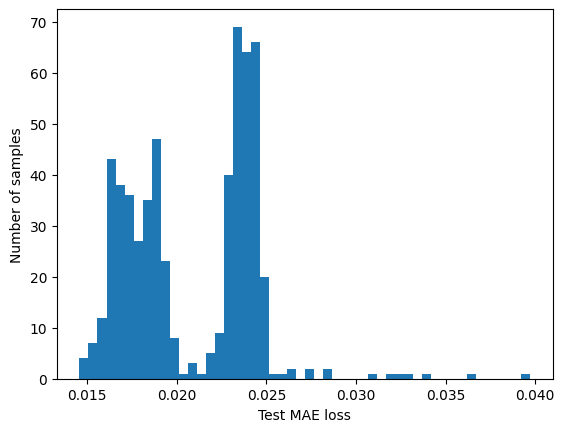

In [47]:
X_test_pred = model.predict(X_test, verbose=1)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [48]:
anomaly_df = pd.DataFrame(test[TIME_STEPS:])
anomaly_df['loss'] = test_mae_loss
anomaly_df['threshold'] = threshold
anomaly_df['anomaly'] = anomaly_df['loss'] > anomaly_df['threshold']

In [49]:
anomaly_df.head()

,timestamp,value,loss,threshold,anomaly
3459,2014-02-26 14:45:00,0.088657,0.015858,0.032848,False
3460,2014-02-26 14:50:00,0.000000,0.016566,0.032848,False
3461,2014-02-26 14:55:00,0.087353,0.016136,0.032848,False
3462,2014-02-26 15:00:00,0.043025,0.016705,0.032848,False
3463,2014-02-26 15:05:00,0.001304,0.016359,0.032848,False


In [50]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [51]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
anomalies.head()

,timestamp,value,loss,threshold,anomaly
3549,2014-02-26 22:15:00,0.000000,0.039728,0.032848,True
3550,2014-02-26 22:20:00,0.044329,0.036688,0.032848,True
3900,2014-02-28 03:30:00,0.001304,0.033759,0.032848,True


In [52]:
anomalies.shape

(3, 5)

In [53]:
anomaly_values = anomaly_df['value'].values.reshape(-1, 1)
anomaly_inverse_values = scaler.inverse_transform(anomaly_values)

anomalies_values = anomalies['value'].values.reshape(-1, 1)
anomalies_inverse_values = scaler.inverse_transform(anomalies_values)

fig = go.Figure()
fig.add_trace(go.Scatter(x=anomaly_df['timestamp'], y=anomaly_inverse_values.flatten(), name='cpu usage'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=anomalies_inverse_values.flatten(), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()
